In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import time

In [6]:

# --- Load model ---
model = tf.keras.models.load_model("trained_model/ResNet50.keras")  


# GradCam Explanation

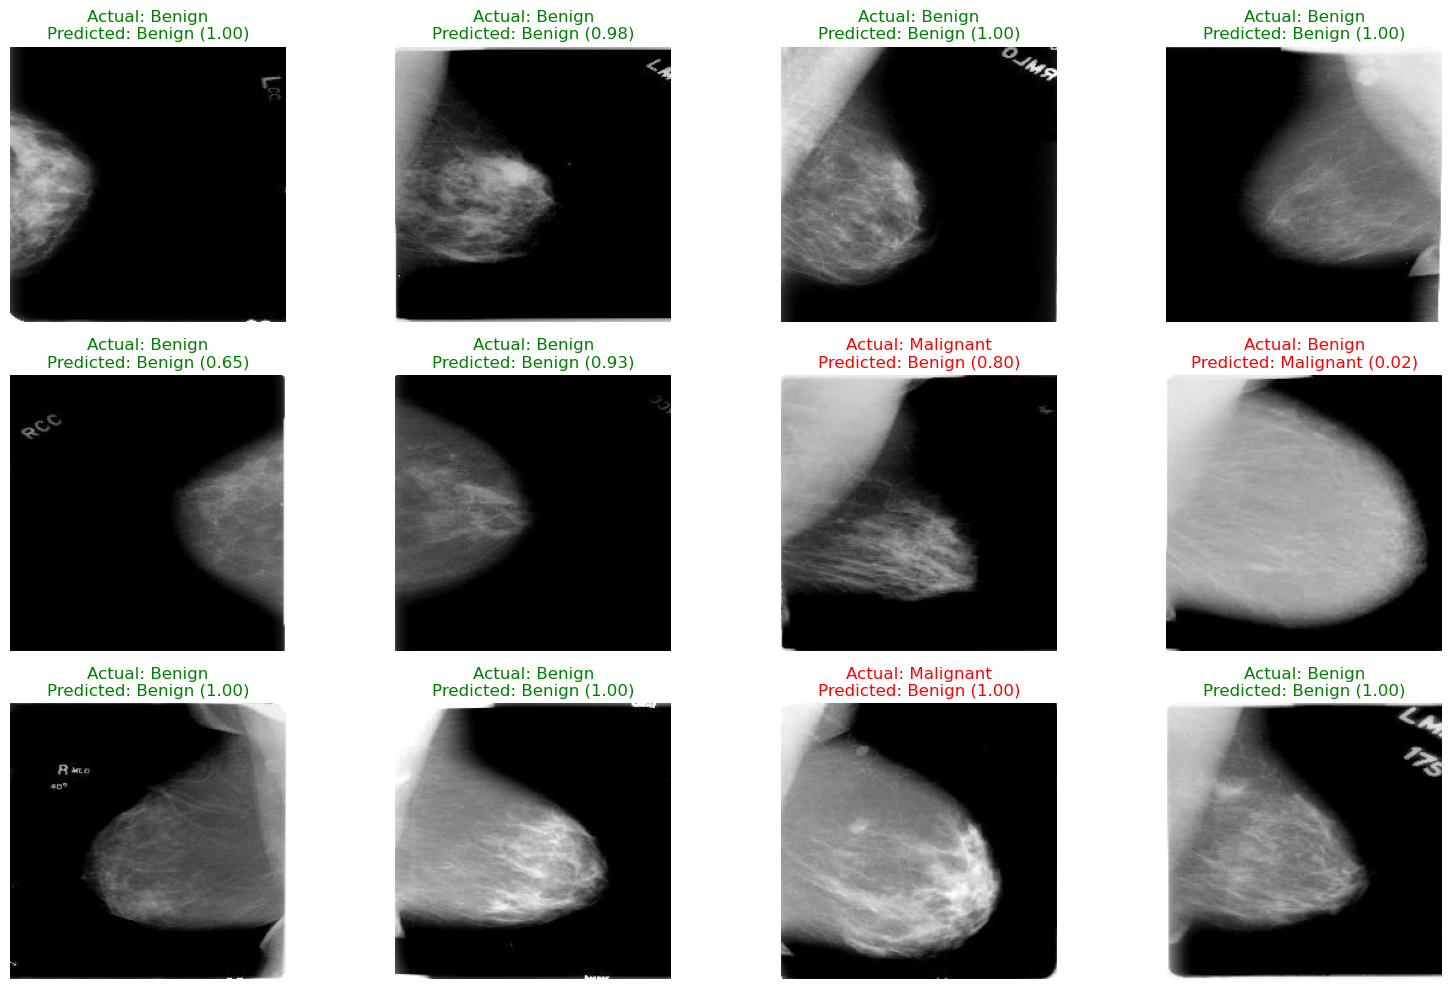

In [7]:

# --- Base directory ---
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"

# --- Parameters ---
img_size = (224, 224)
num_samples = 12

# random.seed(42)

# --- Collect image paths and labels ---
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder_path = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, fname))
            labels.append(int(label_folder))

# --- Random sample ---
sample = random.sample(list(zip(image_paths, labels)), num_samples)
sample_paths, sample_labels = zip(*sample)

# --- Preprocessing + Prediction ---
def preprocess(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0), img

predictions = []
original_imgs = []

for img_path in sample_paths:
    input_arr, orig = preprocess(img_path)
    pred = model.predict(input_arr, verbose=0)[0][0]
    predictions.append(pred)
    original_imgs.append(orig)

# --- Plotting ---
plt.figure(figsize=(16, 10))
for i in range(num_samples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(original_imgs[i])
    actual = "Malignant" if sample_labels[i] == 1 else "Benign"
    predicted = "Malignant" if predictions[i] < 0.5 else "Benign"
    confidence = f"{predictions[i]:.2f}"
    title_color = 'green' if actual == predicted else 'red'
    plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data\0\898f49828c40401db46db21d12bd0e99_1-285.jpg
C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data\1\3763957ce1b14bdd82870d43d2bb620e_1-201.jpg
C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data\1\cce5df1b2a9c4c0c93f2cb8e6e06c1e4_1-032_aug6120.jpg
C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data\0\77d4f1e93a4445ad851ac24fdaf1b6d8_1-185.jpg
C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data\0\46c99019daf0445c98a49034a0f0b551_1-031_aug4722.jpg
C:\Users\Anne\OneDrive - National 

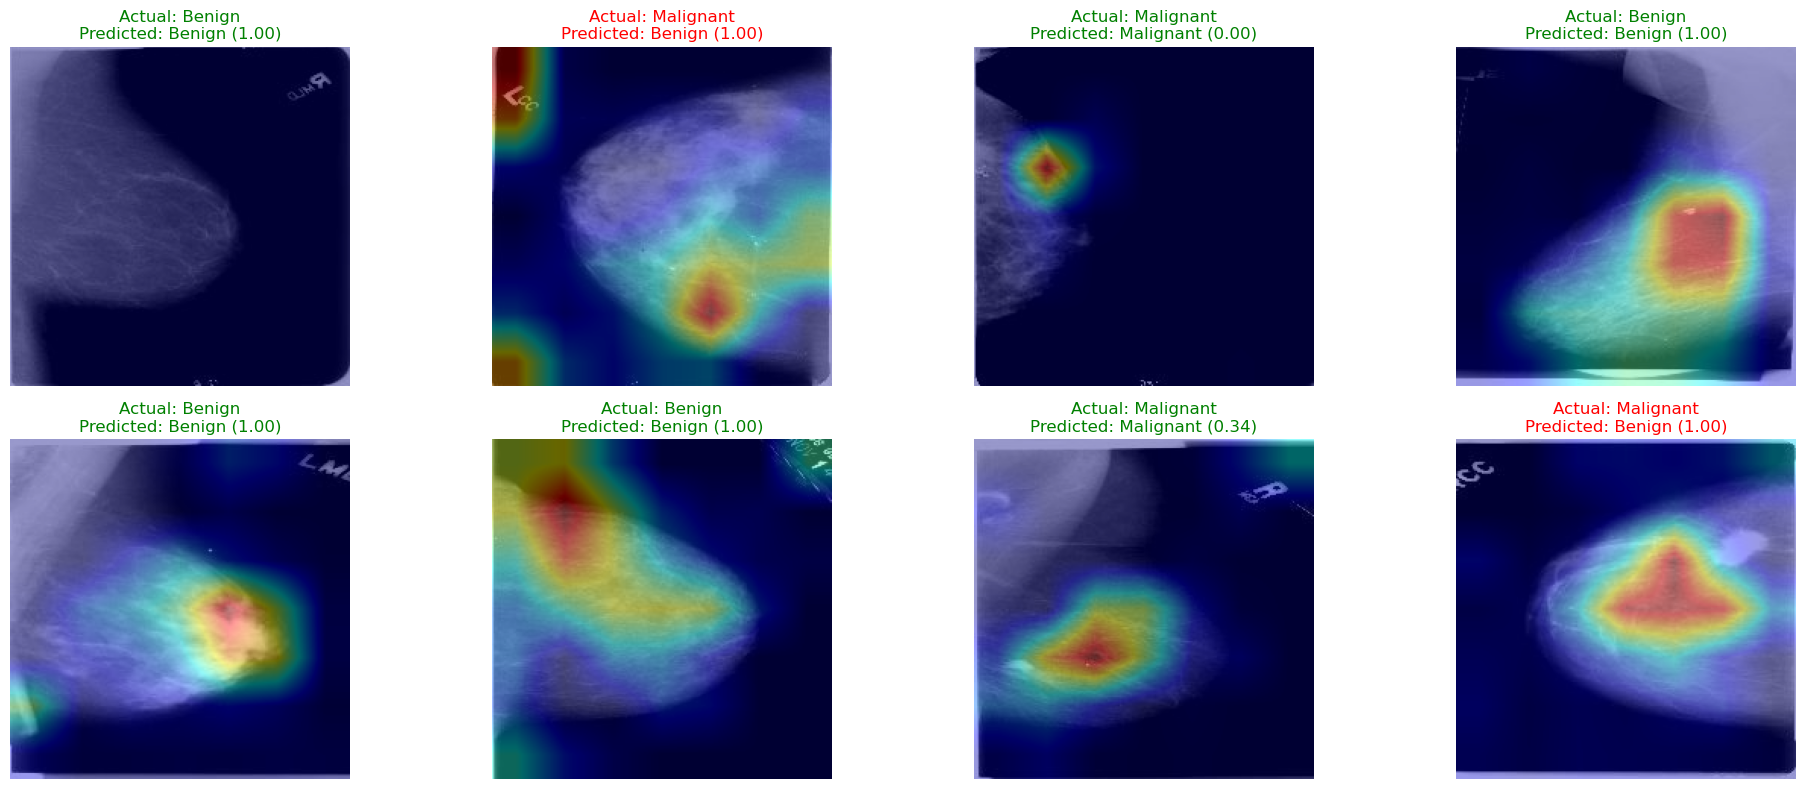

In [33]:
# === Configuration ===
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"
img_size = (224, 224)
num_samples = 8  # Grid: 2 rows x 4 columns

# === Grad-CAM Helper ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_out'):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, 0]  # For sigmoid/binary

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6
    return heatmap

# === Overlay Helper ===
def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

# === Collect images & labels ===
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(int(label_folder))

# === Sample random images ===
sample = random.sample(list(zip(image_paths, labels)), num_samples)
sample_paths, sample_labels = zip(*sample)

# === Predict and Grad-CAM ===
predictions, overlays = [], []

for img_path in sample_paths:
    # Preprocess image
    print(img_path)
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    input_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    input_array = np.expand_dims(input_array, axis=0)

    # Predict
    prob = model.predict(input_array, verbose=0)[0][0]
    predictions.append(prob)

    # Grad-CAM
    heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name='conv5_block3_out') #vgg16 = conv5_block3_out ; resnet = conv5_block3_out; mobilenet = conv_pw_13_relu
    overlay = overlay_gradcam_on_image(img_path, heatmap)
    overlays.append(overlay)

# === Plotting ===
plt.figure(figsize=(20, 8))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    overlay_rgb = cv2.cvtColor(overlays[i], cv2.COLOR_BGR2RGB)
    plt.imshow(overlay_rgb)

    actual = "Malignant" if sample_labels[i] == 1 else "Benign"
    predicted = "Malignant" if predictions[i] < 0.5 else "Benign"
    confidence = f"{predictions[i]:.2f}"
    title_color = "green" if actual == predicted else "red"
    
    plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate Fidelity Score

In [44]:
# === Configuration ===
img_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data\1"
img_size = (224, 224)
last_conv_layer_name = 'conv5_block3_out'
num_samples = 50  # Number of random images to test

# Get all image paths
all_images = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg")]
random_images = random.sample(all_images, num_samples)

# Store fidelity scores
fidelity_scores = []

# === Functions from your code ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, 0]  # Binary class

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6
    return heatmap

def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return img, heatmap_color, overlay

def calculate_fidelity(original_input, heatmap, model):
    heatmap_resized = cv2.resize(heatmap, (img_size[1], img_size[0]))
    mask = heatmap_resized > np.percentile(heatmap_resized, 80)
    mask = mask.astype(np.float32)

    masked_img = original_input.copy()
    masked_img[:, :, 0] *= (1 - mask)
    masked_img[:, :, 1] *= (1 - mask)
    masked_img[:, :, 2] *= (1 - mask)

    input_masked = tf.keras.applications.resnet50.preprocess_input(masked_img.copy())
    input_masked = np.expand_dims(input_masked, axis=0)

    prob_masked = model.predict(input_masked, verbose=0)[0][0]
    return prob_original - prob_masked

# === Loop over random images ===
for img_path in random_images:
    # Load image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    input_array = tf.keras.applications.resnet50.preprocess_input(img_array.copy())
    input_array = np.expand_dims(input_array, axis=0)

    # Original prediction
    prob_original = model.predict(input_array, verbose=0)[0][0]

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(input_array, model, last_conv_layer_name)

    # Fidelity score
    fidelity = calculate_fidelity(img_array, heatmap, model)
    fidelity_scores.append(fidelity)

# Compute average fidelity
average_fidelity = np.mean(fidelity_scores)
print(f"Average Fidelity Score over {num_samples} random images: {average_fidelity:.4f}")


Average Fidelity Score over 50 random images: 0.1634


# Calculate IOU Score

In [34]:
calc_train = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

# Replace the path for cropped_images to the correct directory.
correct_dir = r"C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) 

# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])


def get_image_file_name(data, new_dict):
    for dicom in data:
        key = dicom.split('/')[12]
        new_dict[key] = dicom
    print(f"the length of dataset : {len(new_dict.keys())}")

cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

def fix_image_path(data):
    for indx, image in enumerate(data.values):
        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

fix_image_path(mass_test)

mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_test.head(5)

Cropped Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg
the length of dataset : 571
the length of dataset : 300
the length of dataset : 582


patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

  image_file_path                            cropped_image_file_path  \
0            None  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1            None  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2            None  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
3            None  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....   
4            None  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....   

  ROI_mask_file_path  
0               None  
1               None  
2               None  
3               None  
4               None

C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


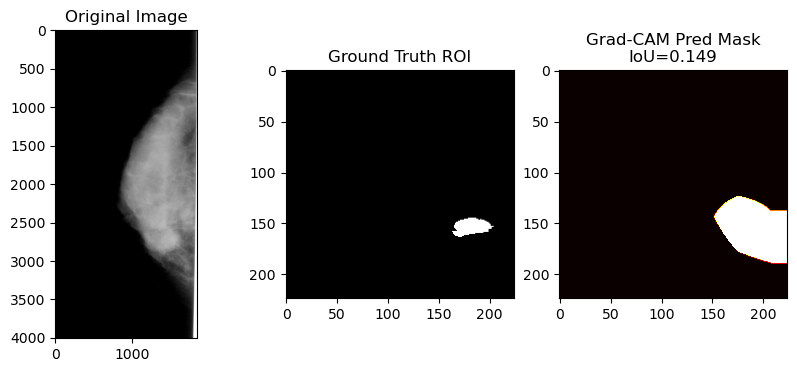

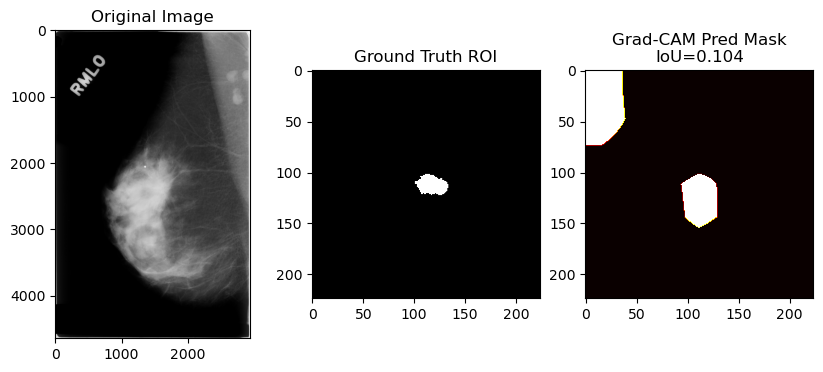

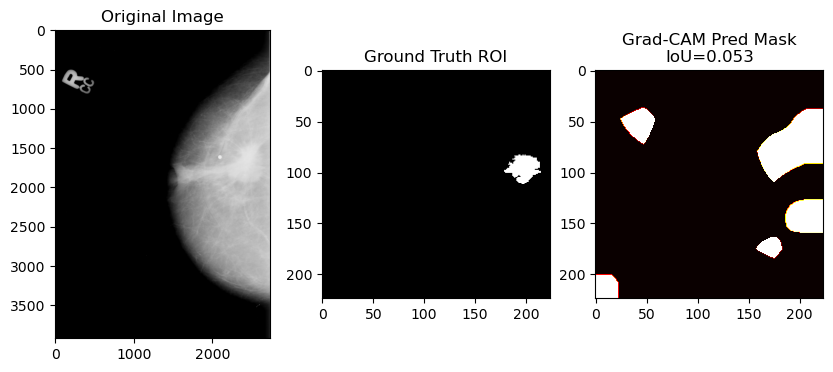

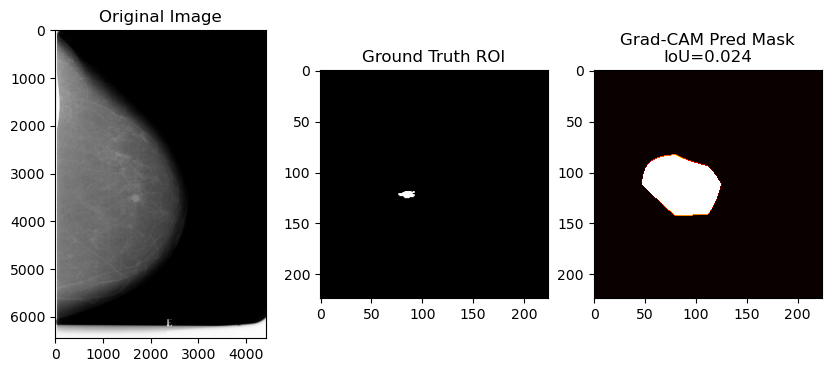

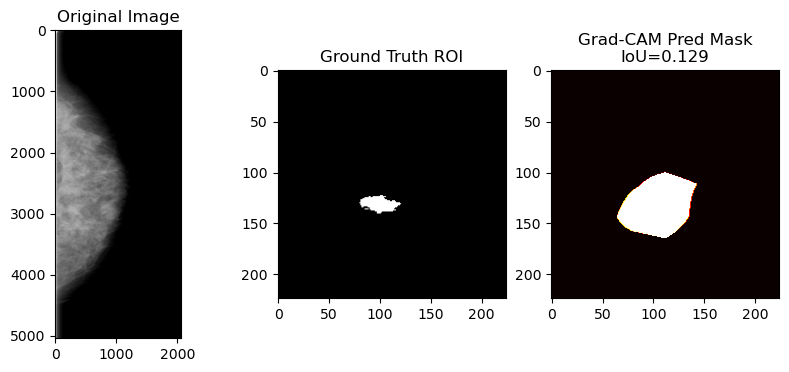

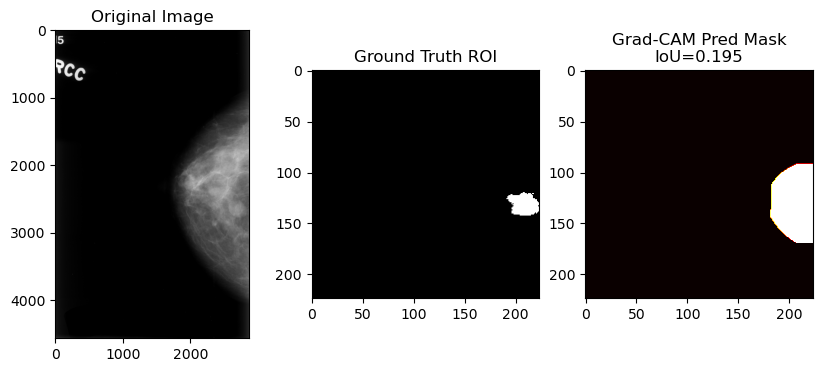

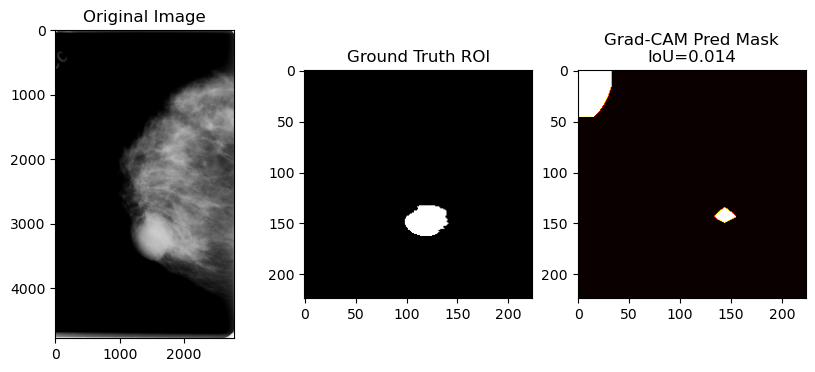

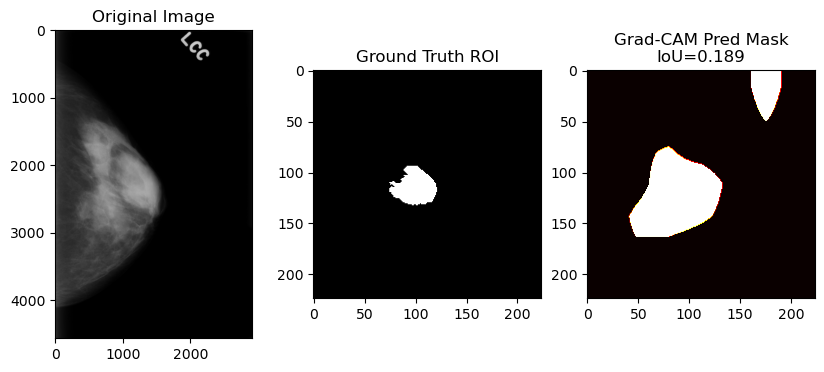

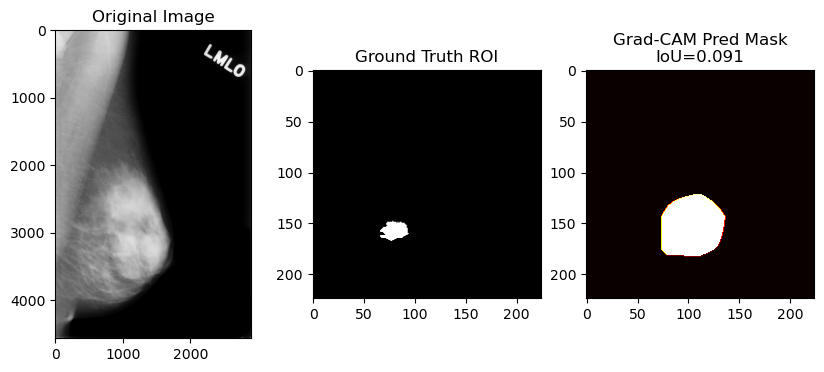

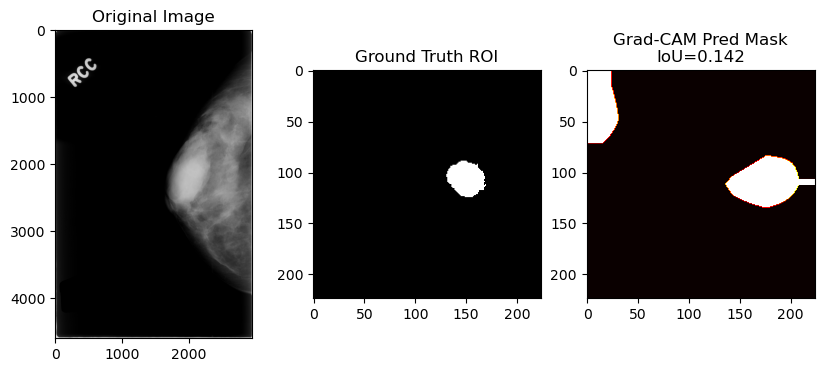

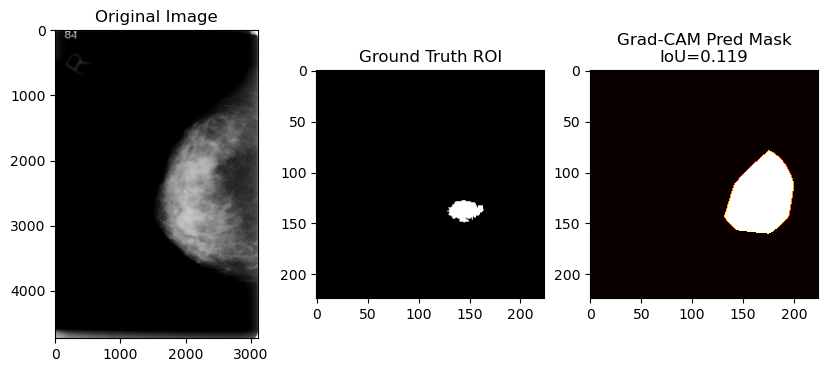

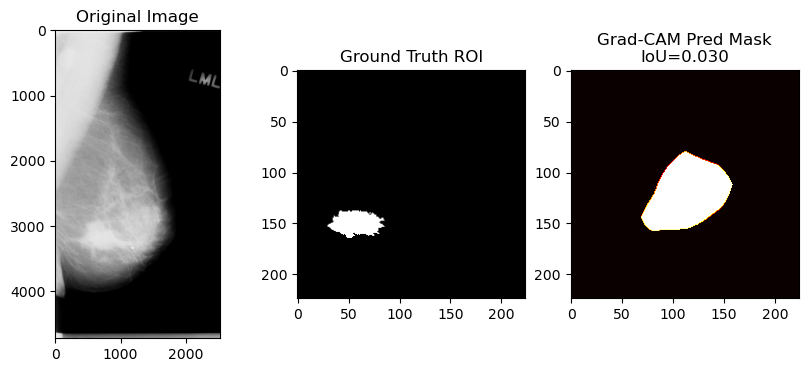

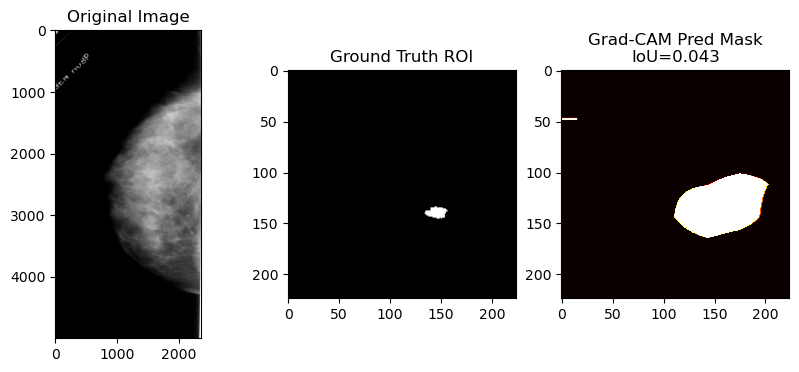

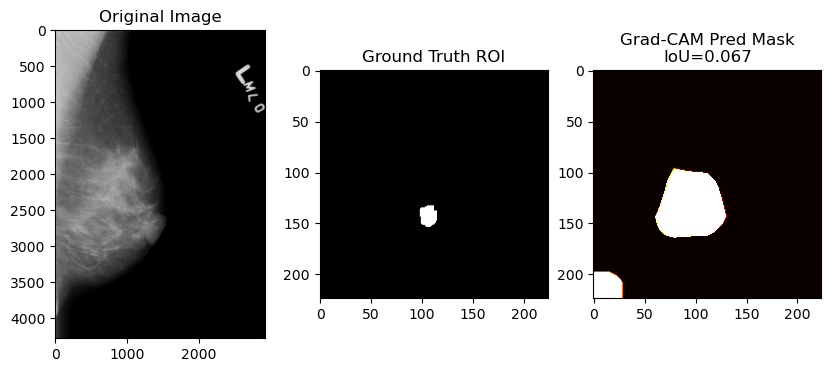

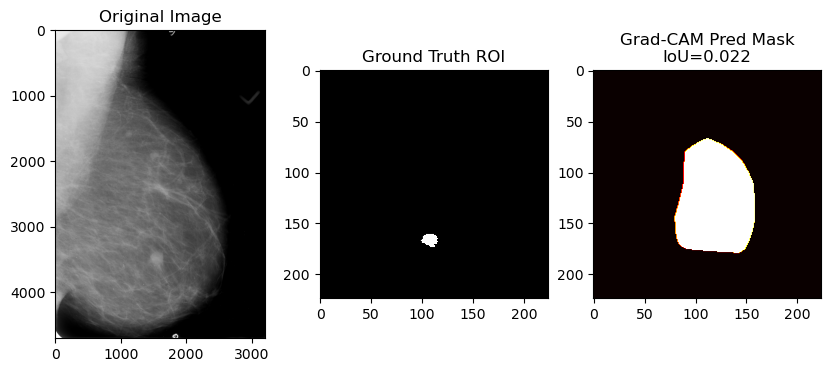

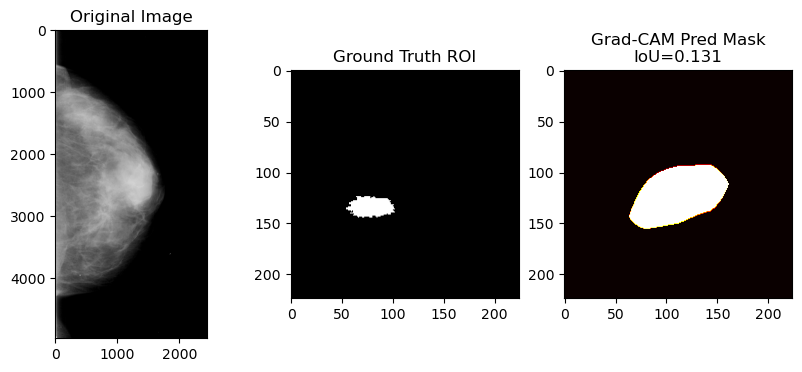

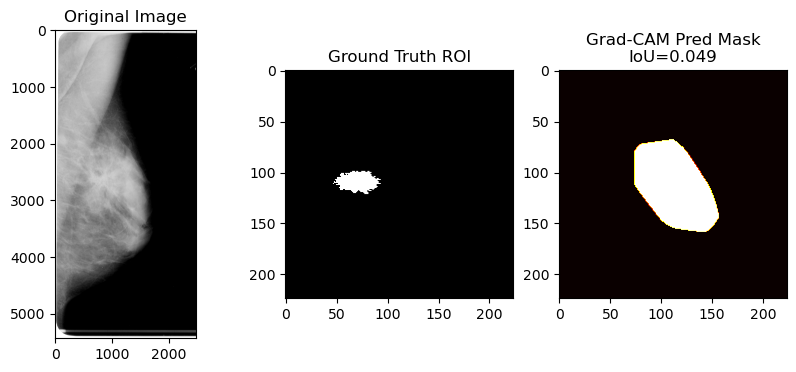

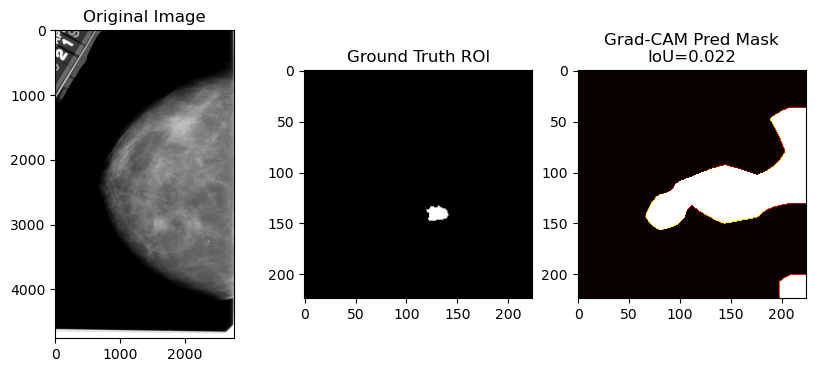

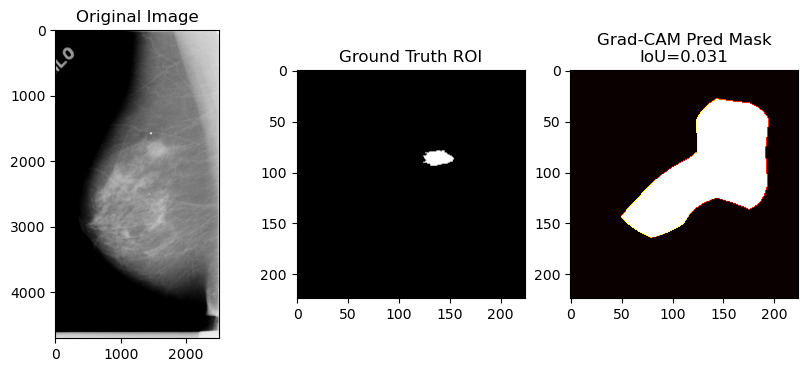

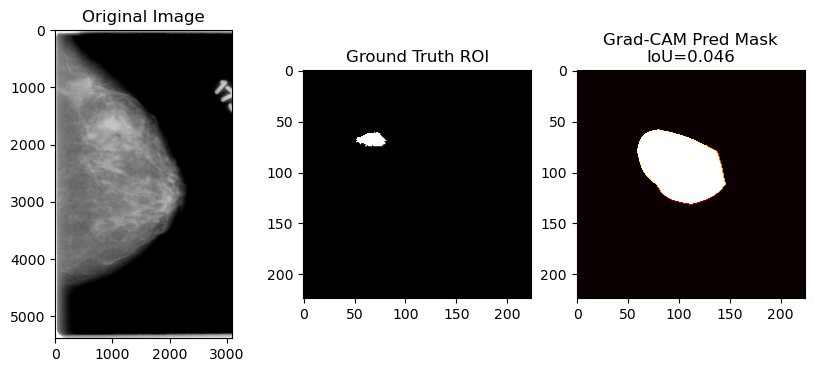

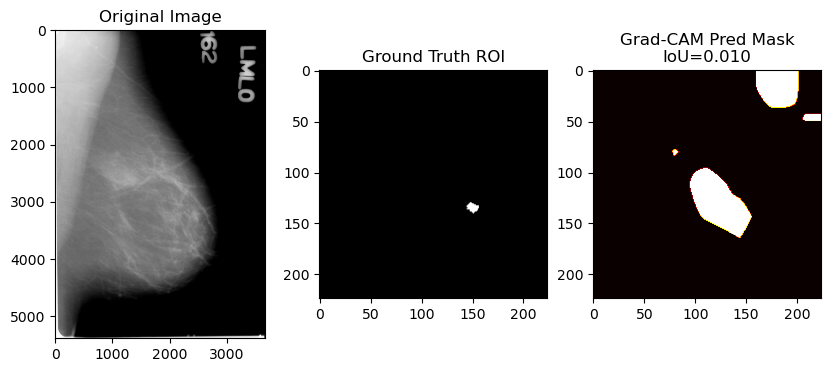

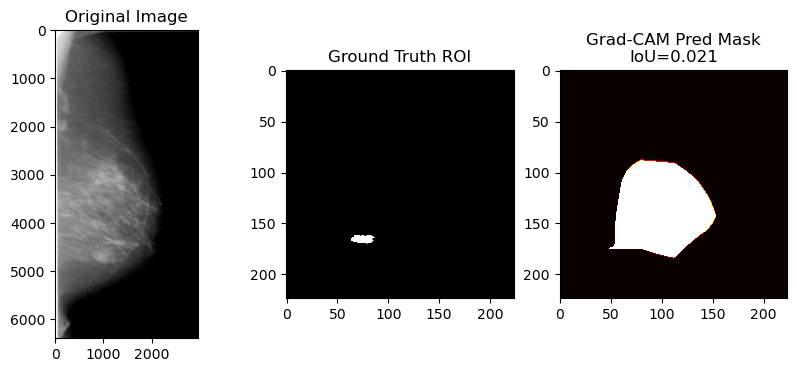

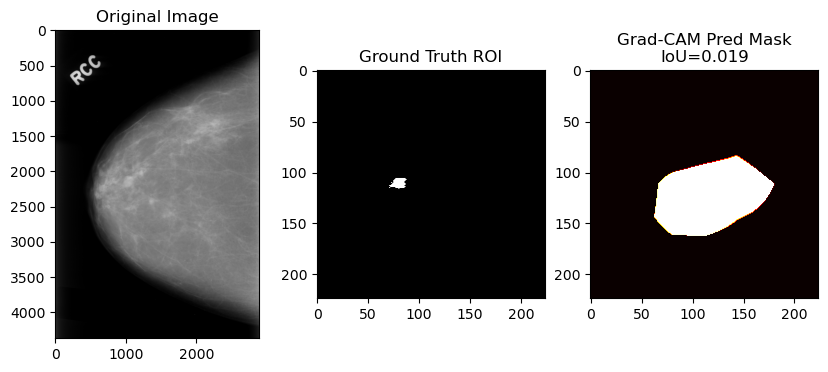

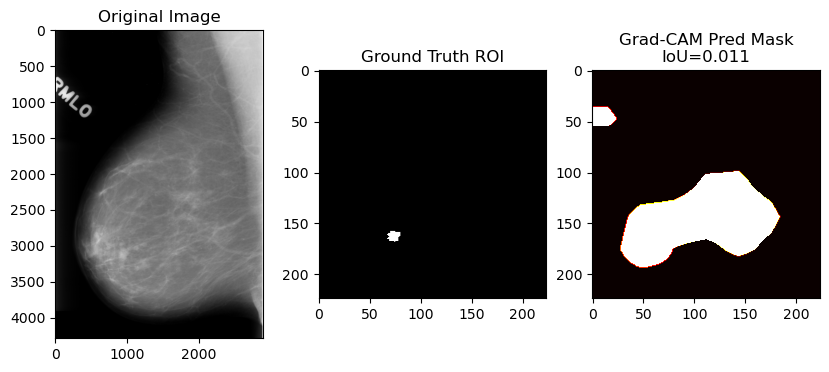

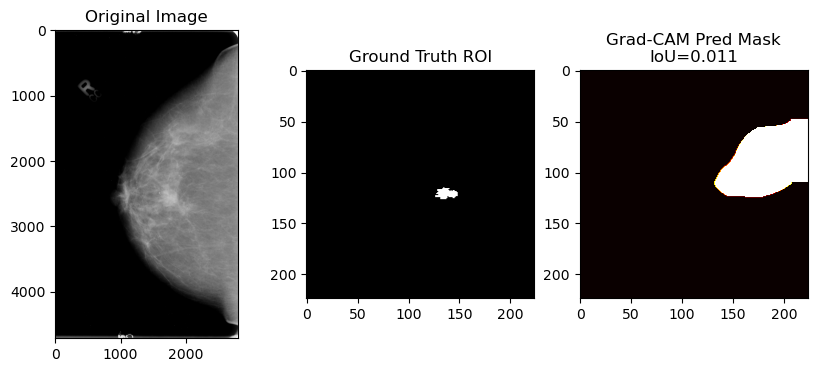

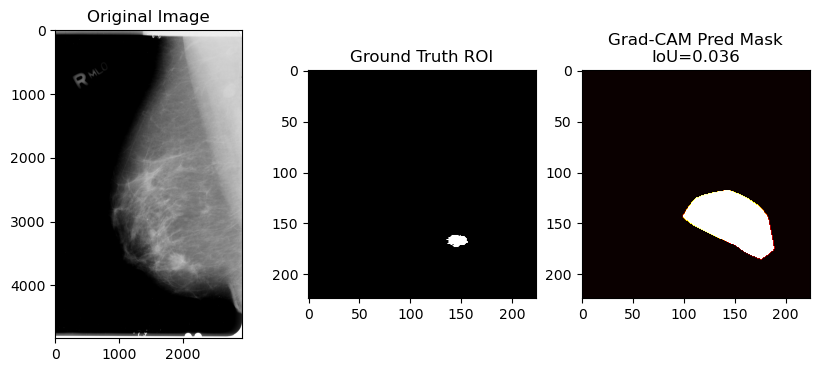

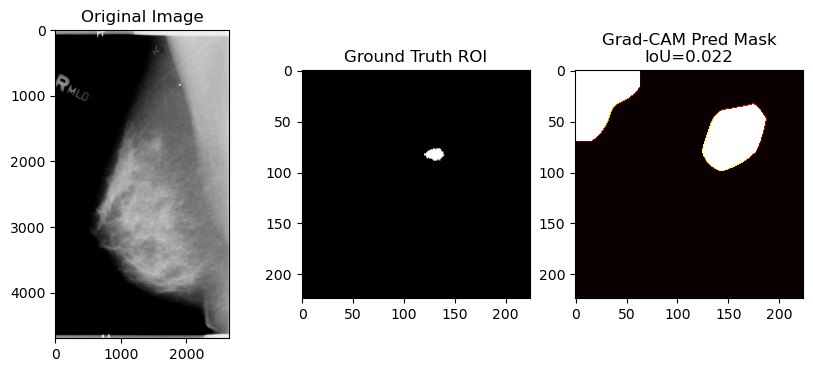

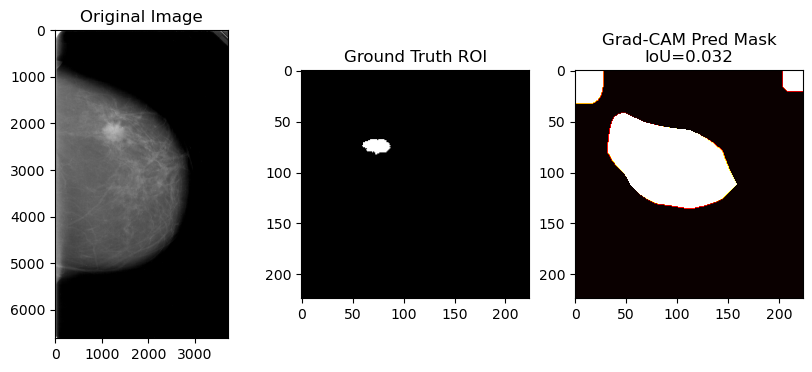

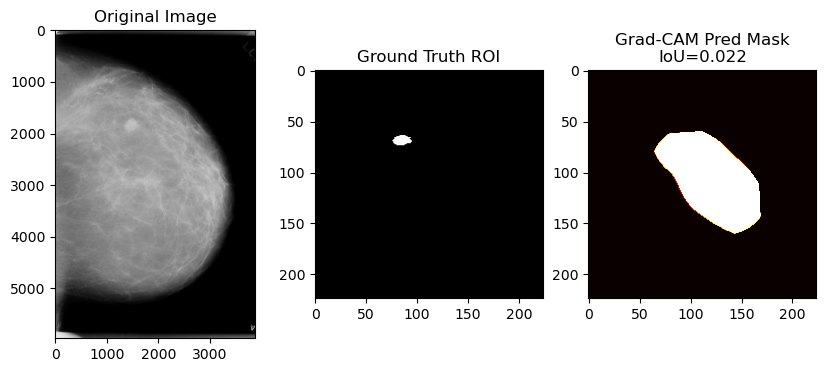

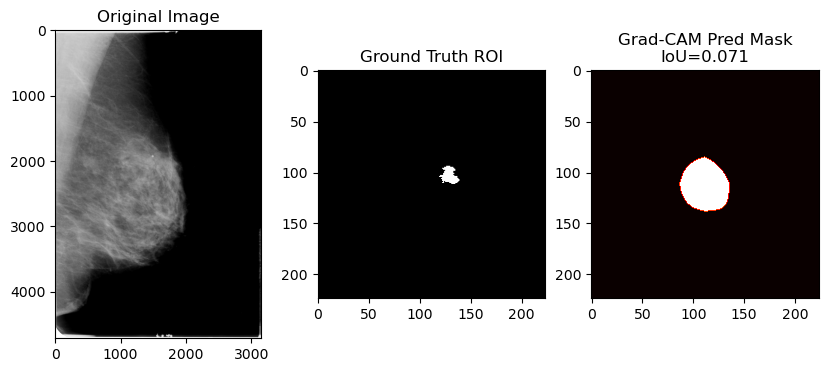

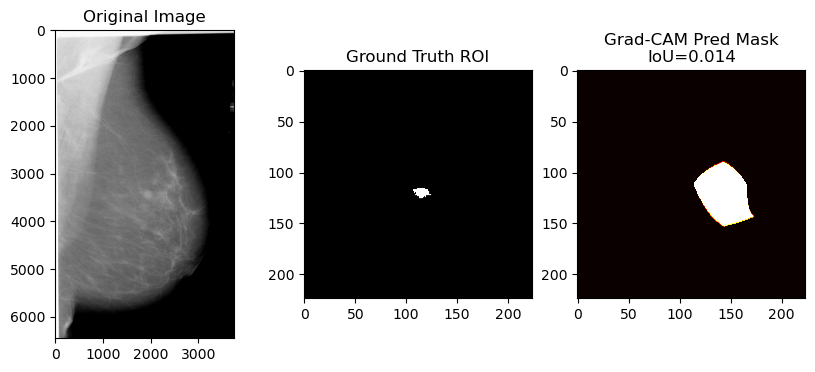

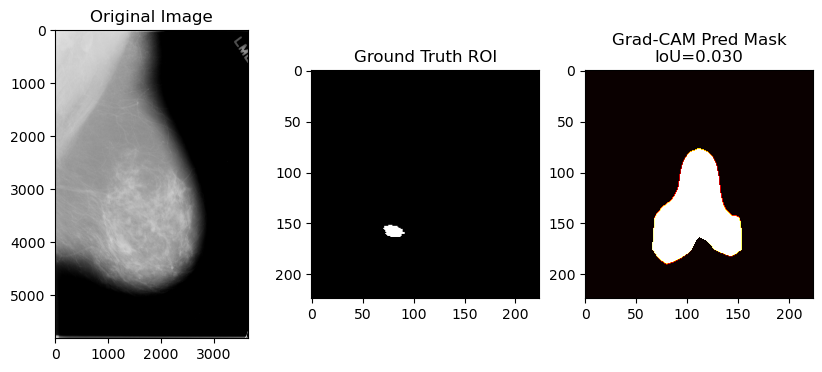

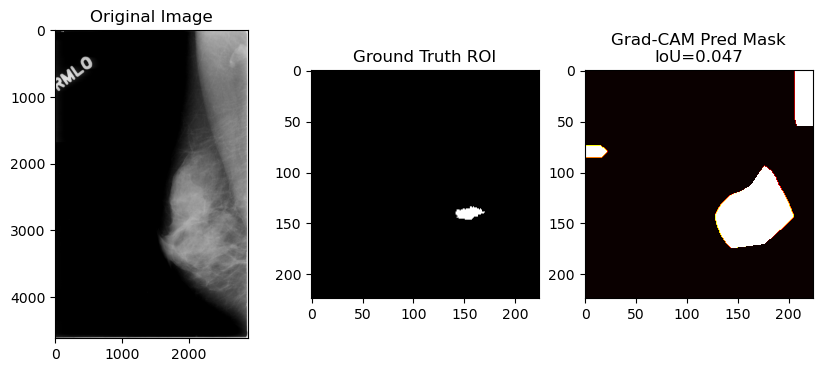

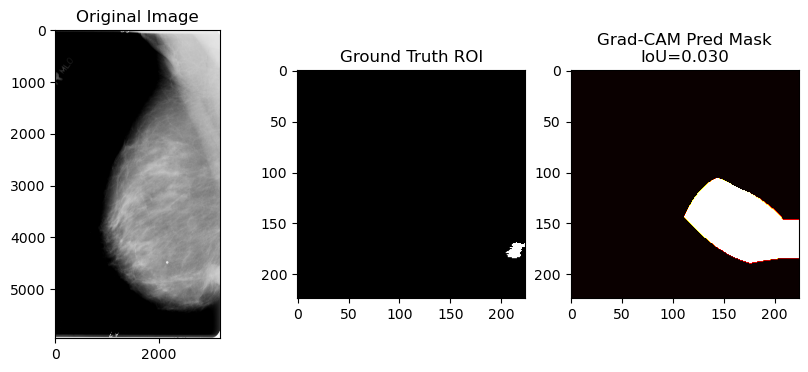

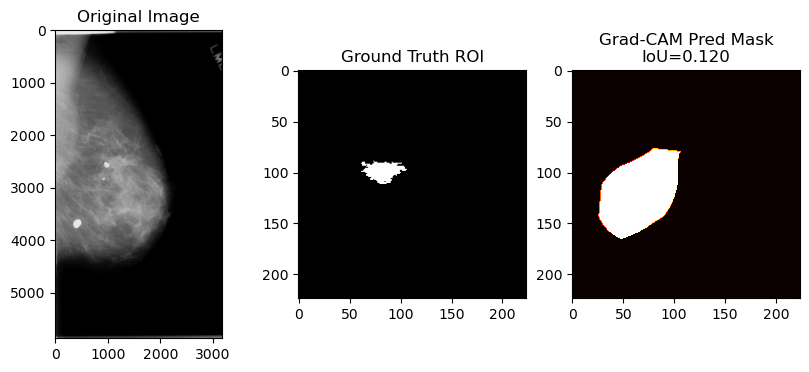

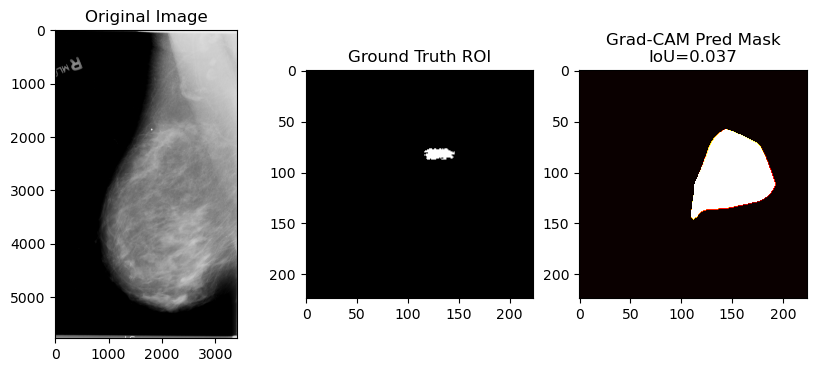

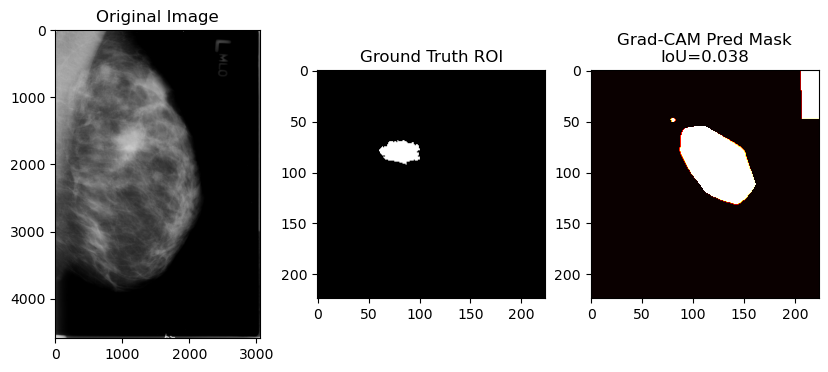

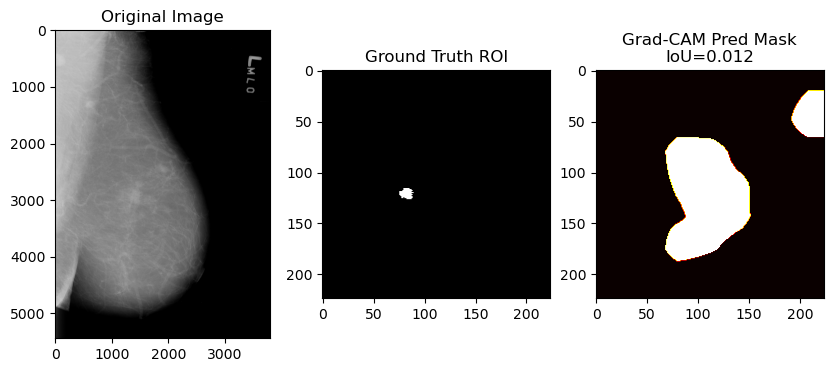

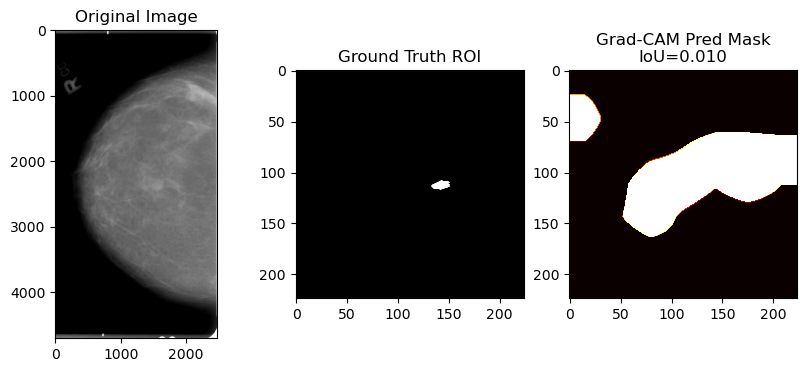

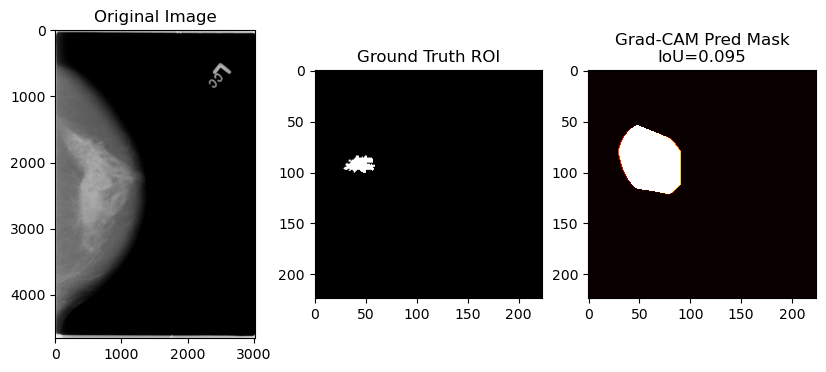

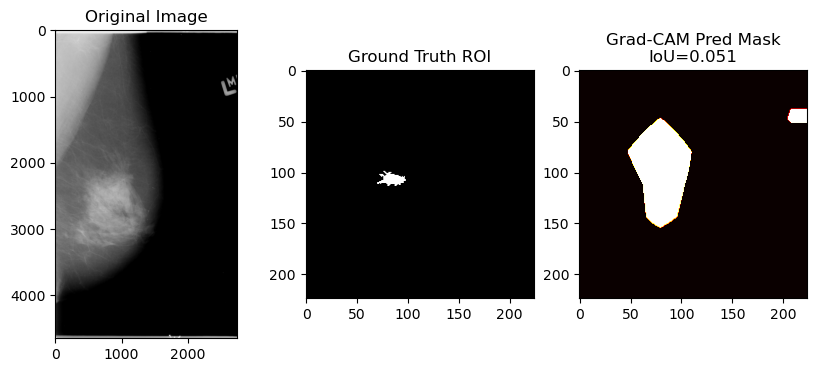

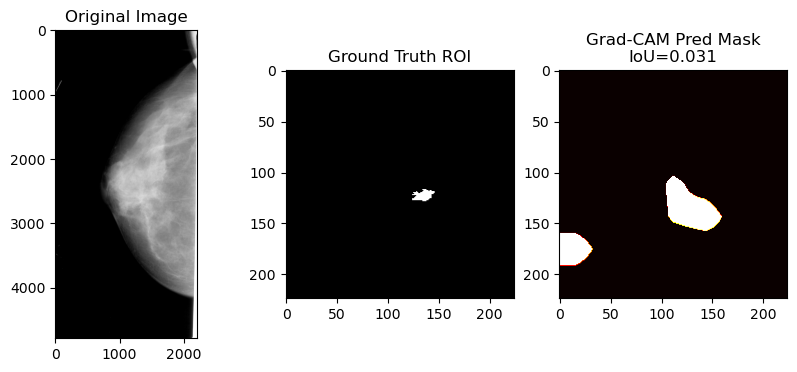

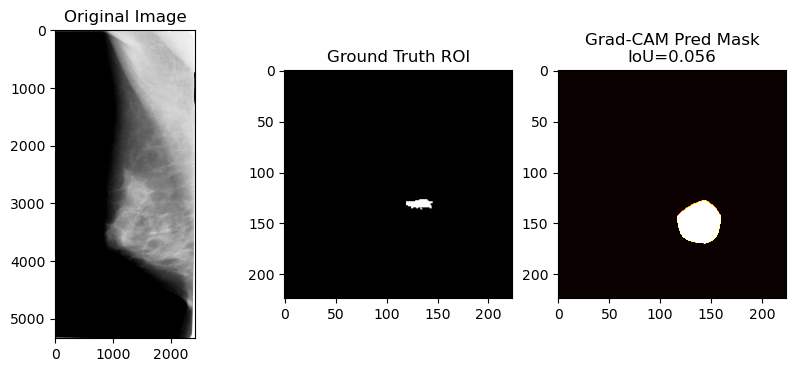

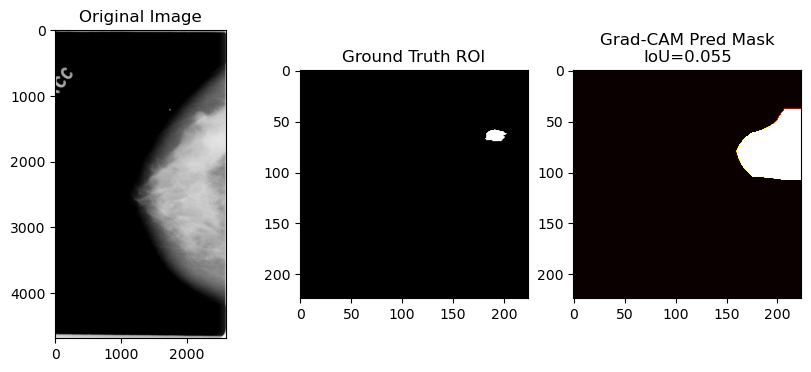

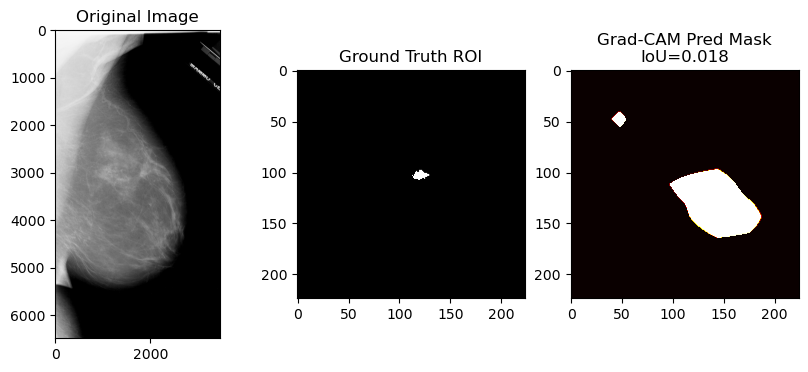

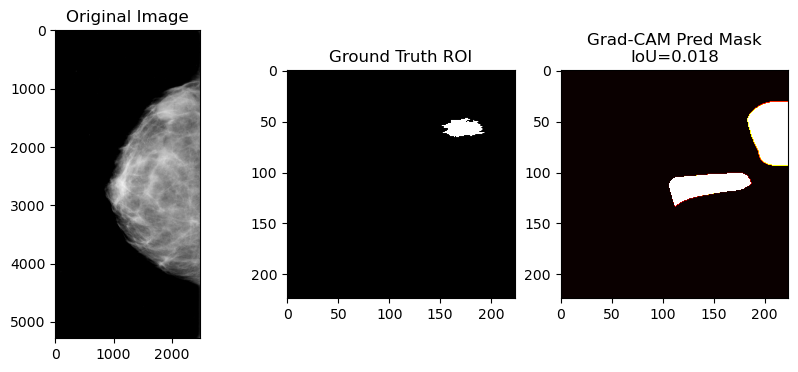

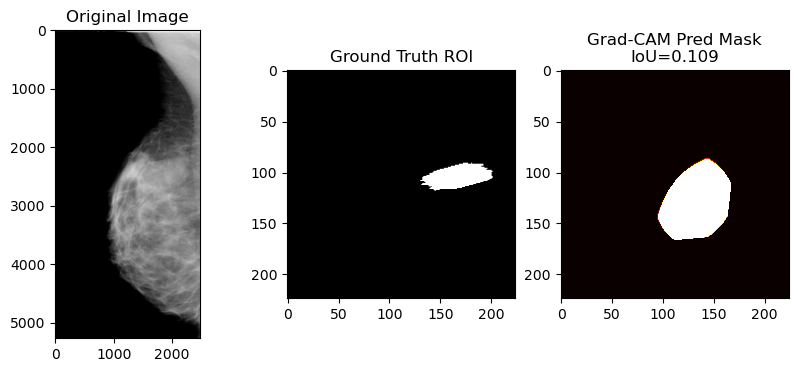

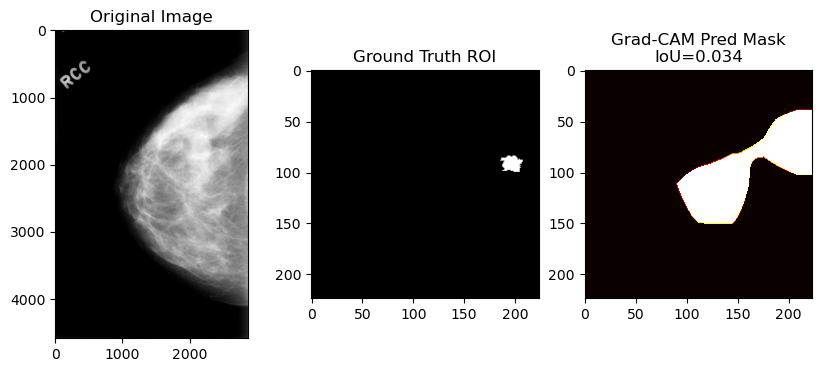

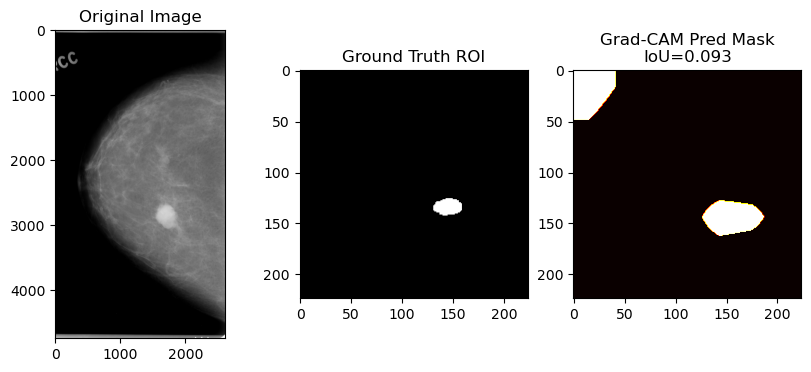

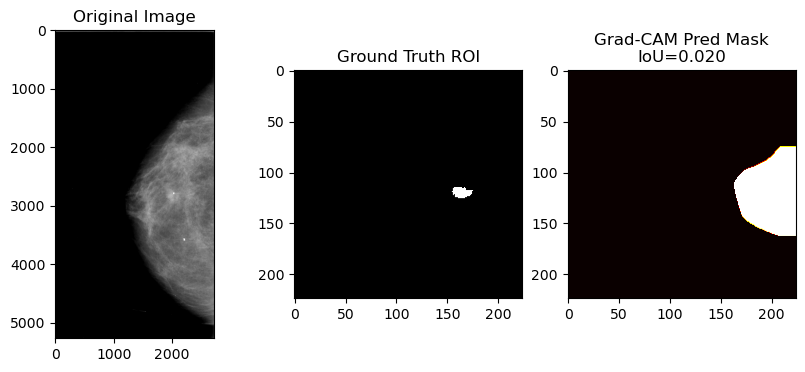

✅ Average IoU (Grad-CAM vs ROI masks): 0.0565


In [ ]:

IMG_SIZE = 224

# ===== Helper functions =====
def load_and_preprocess(img_path, target_size=(IMG_SIZE, IMG_SIZE)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def get_gradcam(model, img_array, class_index=None, layer_name=None):
    if layer_name is None:
        # Default to last conv layer
        for l in reversed(model.layers):
            if 'conv' in l.name:
                layer_name = l.name
                break

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = np.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Convert conv_outputs to numpy
    conv_outputs = conv_outputs[0].numpy()  # shape (H, W, C)
    pooled_grads = pooled_grads.numpy()     # shape (C,)

    # Weighted sum over channels
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.sum(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() + 1e-8  # avoid division by zero
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    return heatmap


def compute_iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return np.nan
    return intersection / union

# ===== Loop over dataset =====
ious = []
for idx, row in mass_test.iterrows():
    if len(ious) >= 50:   # ✅ stop once we have 50 values
        break
    img_path = row['image_file_path']
    roi_mask_path = row['ROI_mask_file_path']

    # Load images
    img_array = load_and_preprocess(img_path)
    roi_mask = cv2.imread(roi_mask_path, cv2.IMREAD_GRAYSCALE)
    roi_mask = cv2.resize(roi_mask, (IMG_SIZE, IMG_SIZE))
    roi_mask = (roi_mask > 127).astype(np.uint8)

    # Grad-CAM
    heatmap = get_gradcam(model, img_array)
    # Threshold heatmap to binary
    pred_mask = (heatmap > 0.5).astype(np.uint8)

    # IoU
    iou_score = compute_iou(pred_mask, roi_mask)
    ious.append(iou_score)

    # Optional: Plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1,3,2)
    plt.imshow(roi_mask, cmap='gray')
    plt.title("Ground Truth ROI")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap='hot')
    plt.title(f"Grad-CAM Pred Mask\nIoU={iou_score:.3f}")
    plt.show()

# ===== Average IoU =====
avg_iou = np.nanmean(ious)
print(f"Average IoU (Grad-CAM vs ROI masks): {avg_iou:.4f}")


# Code to Evaluate Execution Time

Image 1: 0.598 seconds
Image 2: 0.775 seconds
Image 3: 0.641 seconds
Image 4: 0.621 seconds
Image 5: 0.601 seconds
Image 6: 0.612 seconds
Image 7: 0.616 seconds
Image 8: 0.596 seconds

Average time per image: 0.633 seconds


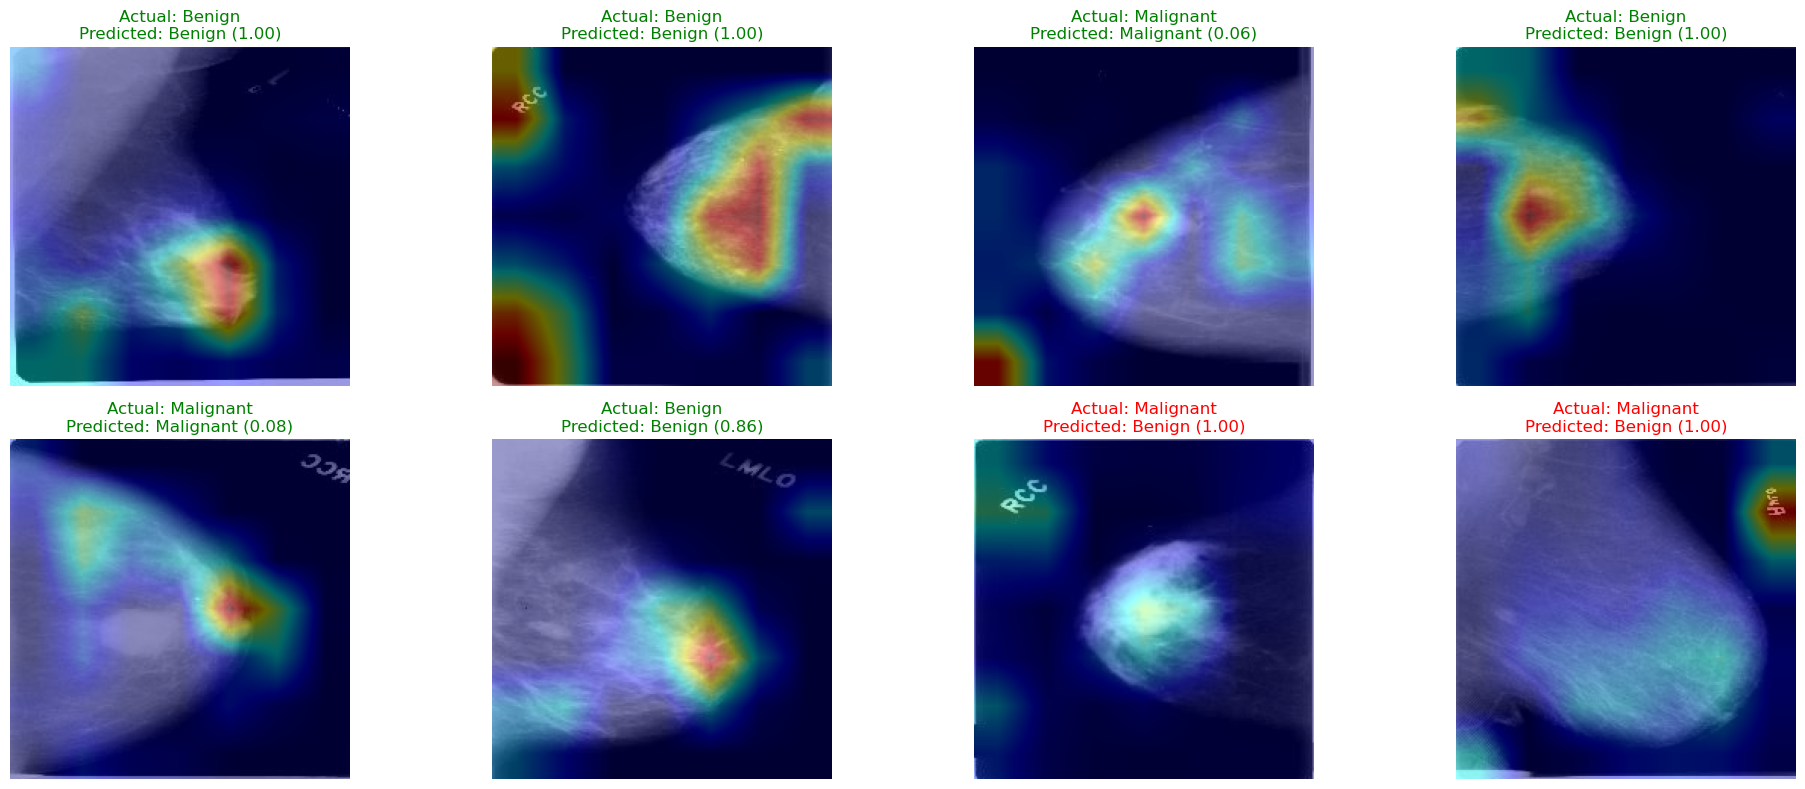

In [41]:
# === Configuration ===
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"
img_size = (224, 224)
num_samples = 8  # Grid: 2 rows x 4 columns

# === Grad-CAM Helper ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_out'):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, 0]  # For sigmoid/binary

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6
    return heatmap

# === Overlay Helper ===
def overlay_gradcam_on_image(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

# === Collect images & labels ===
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(int(label_folder))

# === Sample random images ===
sample = random.sample(list(zip(image_paths, labels)), num_samples)
sample_paths, sample_labels = zip(*sample)

# === Predict, Grad-CAM, and Measure Time ===
predictions, overlays, times_taken = [], [], []

for img_path in sample_paths:
    start_time = time.time()  # start timing
    
    # Preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    input_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    input_array = np.expand_dims(input_array, axis=0)

    # Predict
    prob = model.predict(input_array, verbose=0)[0][0]
    predictions.append(prob)

    # Grad-CAM
    heatmap = make_gradcam_heatmap(
        input_array, model, 
        last_conv_layer_name='conv5_block3_out'  # ResNet50 layer
    )
    overlay = overlay_gradcam_on_image(img_path, heatmap)
    overlays.append(overlay)
    
    end_time = time.time()  # end timing
    times_taken.append(end_time - start_time)

# === Print Timing Info ===
for i, t in enumerate(times_taken):
    print(f"Image {i+1}: {t:.3f} seconds")

print(f"\nAverage time per image: {np.mean(times_taken):.3f} seconds")

# === Plotting Results ===
plt.figure(figsize=(20, 8))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    overlay_rgb = cv2.cvtColor(overlays[i], cv2.COLOR_BGR2RGB)
    plt.imshow(overlay_rgb)

    actual = "Malignant" if sample_labels[i] == 1 else "Benign"
    predicted = "Malignant" if predictions[i] < 0.5 else "Benign"
    confidence = f"{predictions[i]:.2f}"
    title_color = "green" if actual == predicted else "red"
    
    plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()
